# Capstone Project

## Data Modeling and Evaluation

In [43]:
#Import libraries
import pandas as pd
import numpy as np
import gensim.downloader as api
from gensim.models import word2vec
from transformers import pipeline
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
import time;
import logging;
import multiprocessing;
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
#Read in 'twitter_df'
twitter_df = pd.read_csv("../dataset/twitter_df.csv")

In [3]:
#Check shape
twitter_df.shape

(22153, 8)

In [4]:
#Drop Unnamed: 0 column
twitter_df.drop(['Unnamed: 0'], axis=1, inplace=True)

**Remove tweets that contain 'RT' and tweets that were repeated to make sure there is no cluster overlapping**

In [5]:
#Delete the rows that contains 'RT' and reset the index
twitter_df = twitter_df[~twitter_df['tweets'].str.contains('RT')].reset_index(drop=True)

In [6]:
# originaltweets = originaltweets

In [7]:
#Get the rows where number of words in the tweet are > 5
twitter_df = twitter_df[twitter_df['cleaned_tweets'].str.count(' ')  > 5]

In [8]:
#Check the number of duplicated rows
len(twitter_df[twitter_df.duplicated("tweets")])

509

In [9]:
#Drop duplicates
twitter_df =twitter_df.drop_duplicates(subset=['cleaned_tweets'], keep='first').reset_index(drop=True)

### Word2Vec

In [10]:
#Convert tweet into a list of words
X = twitter_df['cleaned_tweets'].str.split().tolist()
len(X)

7111

In [11]:
#https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57
#Initialize Word2Vec Model to build vocabulary out of tweets
# Minimum word count to keep a word which is repeated 100 times in the vocabulary
model = word2vec.Word2Vec(X,min_count=100);

In [12]:
#Check the vocabulary
model.wv.key_to_index.items()

dict_items([('work', 0), ('remote', 1), ('home', 2), ('working', 3), ('office', 4), ('time', 5), ('employee', 6), ('apply', 7), ('business', 8), ('team', 9), ('engineer', 10), ('check', 11), ('company', 12), ('hiring', 13), ('make', 14), ('remotely', 15), ('help', 16), ('full', 17), ('need', 18), ('looking', 19), ('opportunity', 20), ('join', 21), ('want', 22), ('today', 23), ('learn', 24), ('people', 25), ('read', 26), ('senior', 27), ('life', 28), ('software', 29), ('tip', 30), ('developer', 31), ('best', 32), ('manager', 33), ('worker', 34), ('pandemic', 35), ('like', 36), ('many', 37), ('back', 38), ('hybrid', 39), ('online', 40), ('free', 41), ('share', 42), ('role', 43), ('find', 44), ('job', 45), ('know', 46), ('year', 47), ('service', 48), ('customer', 49), ('meeting', 50), ('start', 51), ('take', 52), ('stay', 53), ('great', 54), ('week', 55), ('post', 56), ('product', 57), ('world', 58), ('anywhere', 59), ('virtual', 60), ('marketing', 61), ('experience', 62), ('thing', 63), 

In [13]:
#Code written by Caroline
def get_avg_vec(text):
    try:
        # make a list of only the words in the document that are in the word2vec vocabulary
        valid_words = [word for word in text if word in model.wv.key_to_index]
        if len(valid_words) == 0:
            return np.zeros(shape=(100,))
        else:
            # return average word vector, for words in the document that exist in the vocab
            return np.mean([model.wv.get_vector(word) for word in valid_words], axis=0)
    except AttributeError:
        return np.zeros(shape=(100,))

In [14]:
#Get Mean Vectors for the given data
avg_vecs = [get_avg_vec(doc) for doc in X]

In [15]:
#Convert the avg_vecs into. a dataframe
vec_df = pd.DataFrame(avg_vecs)

In [16]:
#Concatenate 'twitter_df' and 'vec_df'
df_vec = pd.concat([twitter_df, vec_df], axis=1).reset_index(drop=True)

In [17]:
#Display first five rows after Concatenation
df_vec.head()

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal mean need remote t...,"New York, NY",US,1,0.053410,0.023902,0.074025,...,0.238595,0.260278,0.098642,0.090707,0.217438,0.053968,0.079616,-0.051768,0.009385,-0.056512
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,US,1,0.029542,0.017841,0.128235,...,0.244558,0.273559,0.089147,0.084905,0.209419,0.044736,0.067842,-0.066869,-0.017670,-0.067174
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open excellent report remote advert ...,Sydney | Hong Kong | Singapore,HK,1,0.041064,0.024633,0.111308,...,0.239888,0.262442,0.084214,0.077230,0.198793,0.042421,0.073463,-0.066272,-0.016420,-0.074710
3,1416180231350759425,2021-07-16 23:37:33+00:00,🚑 These are the tools that will save your #Rem...,tool save google meet tool created love want know,"Duluth, GA",US,0,0.057402,0.035333,0.045828,...,0.242261,0.250395,0.092509,0.094623,0.220986,0.060780,0.086350,-0.044944,0.020601,-0.051614
4,1416178372296675331,2021-07-16 23:30:09+00:00,Would you consider outsourcing a project to so...,would consider outsourcing project someone nev...,Global,None,0,0.062932,0.028304,0.071627,...,0.244615,0.275369,0.092323,0.086946,0.220974,0.053600,0.086950,-0.056517,0.021403,-0.058001


In [18]:
#Consider only Vectorized columns 
vec_col = df_vec.columns[7:]
vec_col_names = df_vec[vec_col]

In [19]:
#Scale the Vectorized Columns
X_vec=vec_col_names
sc = StandardScaler()
X_vec_sc = sc.fit_transform(X_vec)
X_vec_sc[0:1]

array([[ 0.20442296, -0.37914602,  0.07392528,  0.21879262,  0.24820757,
        -0.13376633,  0.05983729,  0.11999327, -0.12785443, -0.1547913 ,
         0.2069    , -0.18020433, -0.07258274,  0.29048321, -0.01699158,
         0.30271565,  0.14316603, -0.14162033, -0.04743949, -0.14125601,
         0.07715383, -0.63802732,  0.03118111, -0.2937735 ,  0.44021586,
        -0.07565379, -0.10552636,  0.03767607, -0.15956379,  0.12872331,
         0.1982983 ,  0.00632745,  0.12476313, -0.02319096,  0.00779836,
         0.09368836,  0.04135873, -0.39322276,  0.16207828, -0.19582817,
         0.21129352, -0.25375708, -0.36509028,  0.08986687,  0.06542232,
         0.2054195 , -0.0939202 , -0.06588864,  0.01675798,  0.20833735,
         0.34975253, -0.36814301,  0.00493892,  0.36915806,  0.14796455,
         0.21301105,  0.12513658,  0.1211291 , -0.15032559,  0.25826748,
        -0.14865196,  0.13889534,  0.12083452,  0.14206612, -0.22980691,
         0.13947925,  0.28544809,  0.1260817 , -0.0

In [20]:
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
#Find the optimal 'n_clusters'  between 3 and 16 using 'Elbow Method'
Sum_of_squared_distances_word2vec = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_vec_sc)
    Sum_of_squared_distances_word2vec.append(kmeans.inertia_)

### CountVectorizer

In [21]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
#Instantiate and fit the CountVectorizer
cv = CountVectorizer(max_features=3500) 
X_cv = cv.fit_transform(twitter_df['cleaned_tweets'].astype('U'))  

In [22]:
# Convert X_cv into a dataframe
X_cv_df = pd.DataFrame(X_cv.toarray(), columns = cv.get_feature_names())

In [23]:
# Check shape of X_cv_df
print(f'Shape of X_cv_df: {X_cv_df.shape}')

Shape of X_cv_df: (7111, 3500)


In [24]:
#Concatenate 'twitter_df' and 'X_cv_df'
df_cv = pd.concat([twitter_df, X_cv_df], axis=1).reset_index(drop=True)

In [25]:
#Display first three rows after Concatenation
df_cv.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,ability,able,absence,...,yesterday,yoga,york,young,younger,youtube,zero,zoho,zone,zoom
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal mean need remote t...,"New York, NY",US,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,US,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open excellent report remote advert ...,Sydney | Hong Kong | Singapore,HK,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Consider only Vectorized columns 
cv_col = df_cv.columns[7:]
cv_col_names = df_cv[cv_col]

In [27]:
#Scale the Vectorized Columns
X_cv=cv_col_names
sc = StandardScaler()
X_cv_sc = sc.fit_transform(X_cv)
X_cv_sc[0:1]

array([[-0.06173659, -0.07623514, -0.01591204, ..., -0.02054409,
        -0.05836702, -0.09165462]])

In [28]:
#Find the optimal 'n_clusters'  between 3 and 16 using 'Elbow Method'
Sum_of_squared_distances_cv = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cv_sc)
    Sum_of_squared_distances_cv.append(kmeans.inertia_)

### Tfidf Vectorizer

In [29]:
#Instantiate and fit the TFIDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(twitter_df['cleaned_tweets'].astype('U')) 

In [30]:
# Convert X_tfidf into a dataframe
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf.get_feature_names())

In [31]:
# Check shape of X_tfidf_df
print(f'Shape of X_tfidf_df: {X_tfidf_df.shape}')

Shape of X_tfidf_df: (7111, 5000)


In [32]:
#Concatenate 'twitter_df' and 'X_tfidf_df'
df_tfidf = pd.concat([twitter_df, X_tfidf_df], axis=1).reset_index(drop=True)

In [33]:
#Display first three rows after Concatenation
df_tfidf.head(3)

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,ababa,abandon,ability,...,zealand,zealander,zebra,zero,zoho,zombie,zone,zoom,zooming,zubair
0,1416181616846811137,2021-07-16 23:43:03+00:00,🏡 #RemoteWork is on the rise &amp; slowly beco...,rise slowly becoming normal mean need remote t...,"New York, NY",US,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1416181380279635970,2021-07-16 23:42:07+00:00,Opportunity to join a fantastic team at a hi-t...,opportunity join fantastic team tech fast pace...,London | New York,US,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1416181225979473920,2021-07-16 23:41:30+00:00,Good news for #JobSeekers open to #RemoteWork!...,good news open excellent report remote advert ...,Sydney | Hong Kong | Singapore,HK,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Consider only Vectorized columns 
tfidf_col = df_tfidf.columns[7:]
tfidf_col_names = df_tfidf[tfidf_col]

In [35]:
#Scale the Vectorized Columns
X_tfidf=tfidf_col_names
sc = StandardScaler()
X_tfidf_sc = sc.fit_transform(X_tfidf)
X_tfidf_sc[0:1]

array([[-0.01676766, -0.01676178, -0.06046767, ..., -0.09038836,
        -0.01651335, -0.01185947]])

In [36]:
#Find the optimal 'n_clusters'  between 3 and 16 using 'Elbow Method'
Sum_of_squared_distances_tfidf = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_tfidf_sc)
    Sum_of_squared_distances_tfidf.append(kmeans.inertia_)

## Evaluation

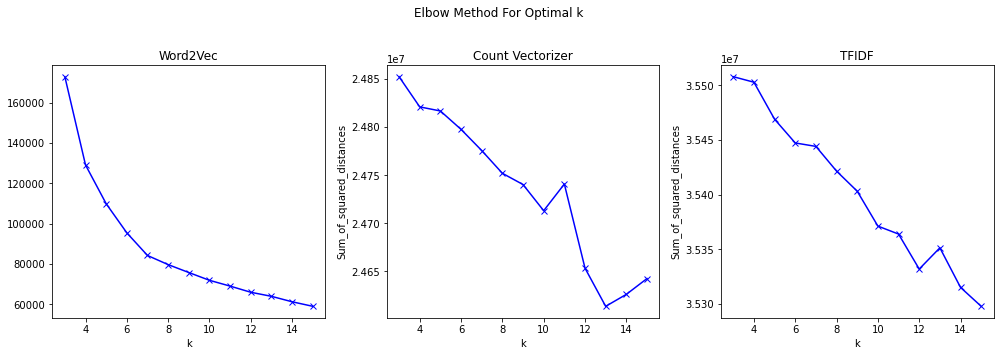

In [37]:
#Plot the 'Elbow Method For Optimal k'
plt.subplots(1, 3, figsize=(14,5))
plt.suptitle('Elbow Method For Optimal k \n')

plt.subplot(1, 3, 1)
plt.plot(range(3, 16), Sum_of_squared_distances_word2vec, 'bx-')
plt.xlabel('k')
plt.title('Word2Vec')

plt.subplot(1, 3, 2)
plt.plot(range(3, 16), Sum_of_squared_distances_cv, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances');
plt.title('Count Vectorizer')

plt.subplot(1,3,3)
plt.plot(range(3, 16), Sum_of_squared_distances_tfidf, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances');
plt.title('TFIDF')
plt.tight_layout()

- **According to the Elbow Method, if the plot looks like an arm, then the elbow on the arm is optimal k.**
- **By looking at the above plots,Word2Vec plot looks like an arm and hence going ahead with Word2Vec data**
- **Optimal number of clusters would be '4'**

In [38]:
#Initialise K-means
km_vec = KMeans(n_clusters=4, random_state=42)
km_vec.fit(X_vec_sc)

KMeans(n_clusters=4, random_state=42)

In [39]:
#Create a column 'km' and store the cluster labels
df_vec['km']=km_vec.labels_

In [40]:
#Check the number of rows on each cluster
df_vec['km'].value_counts()

1    3680
0    2148
3    1084
2     199
Name: km, dtype: int64

In [41]:
#Get silhouette_score to check how cluster has performed
ss = silhouette_score(X_vec_sc,km_vec.labels_)
ss

0.35726446238413395

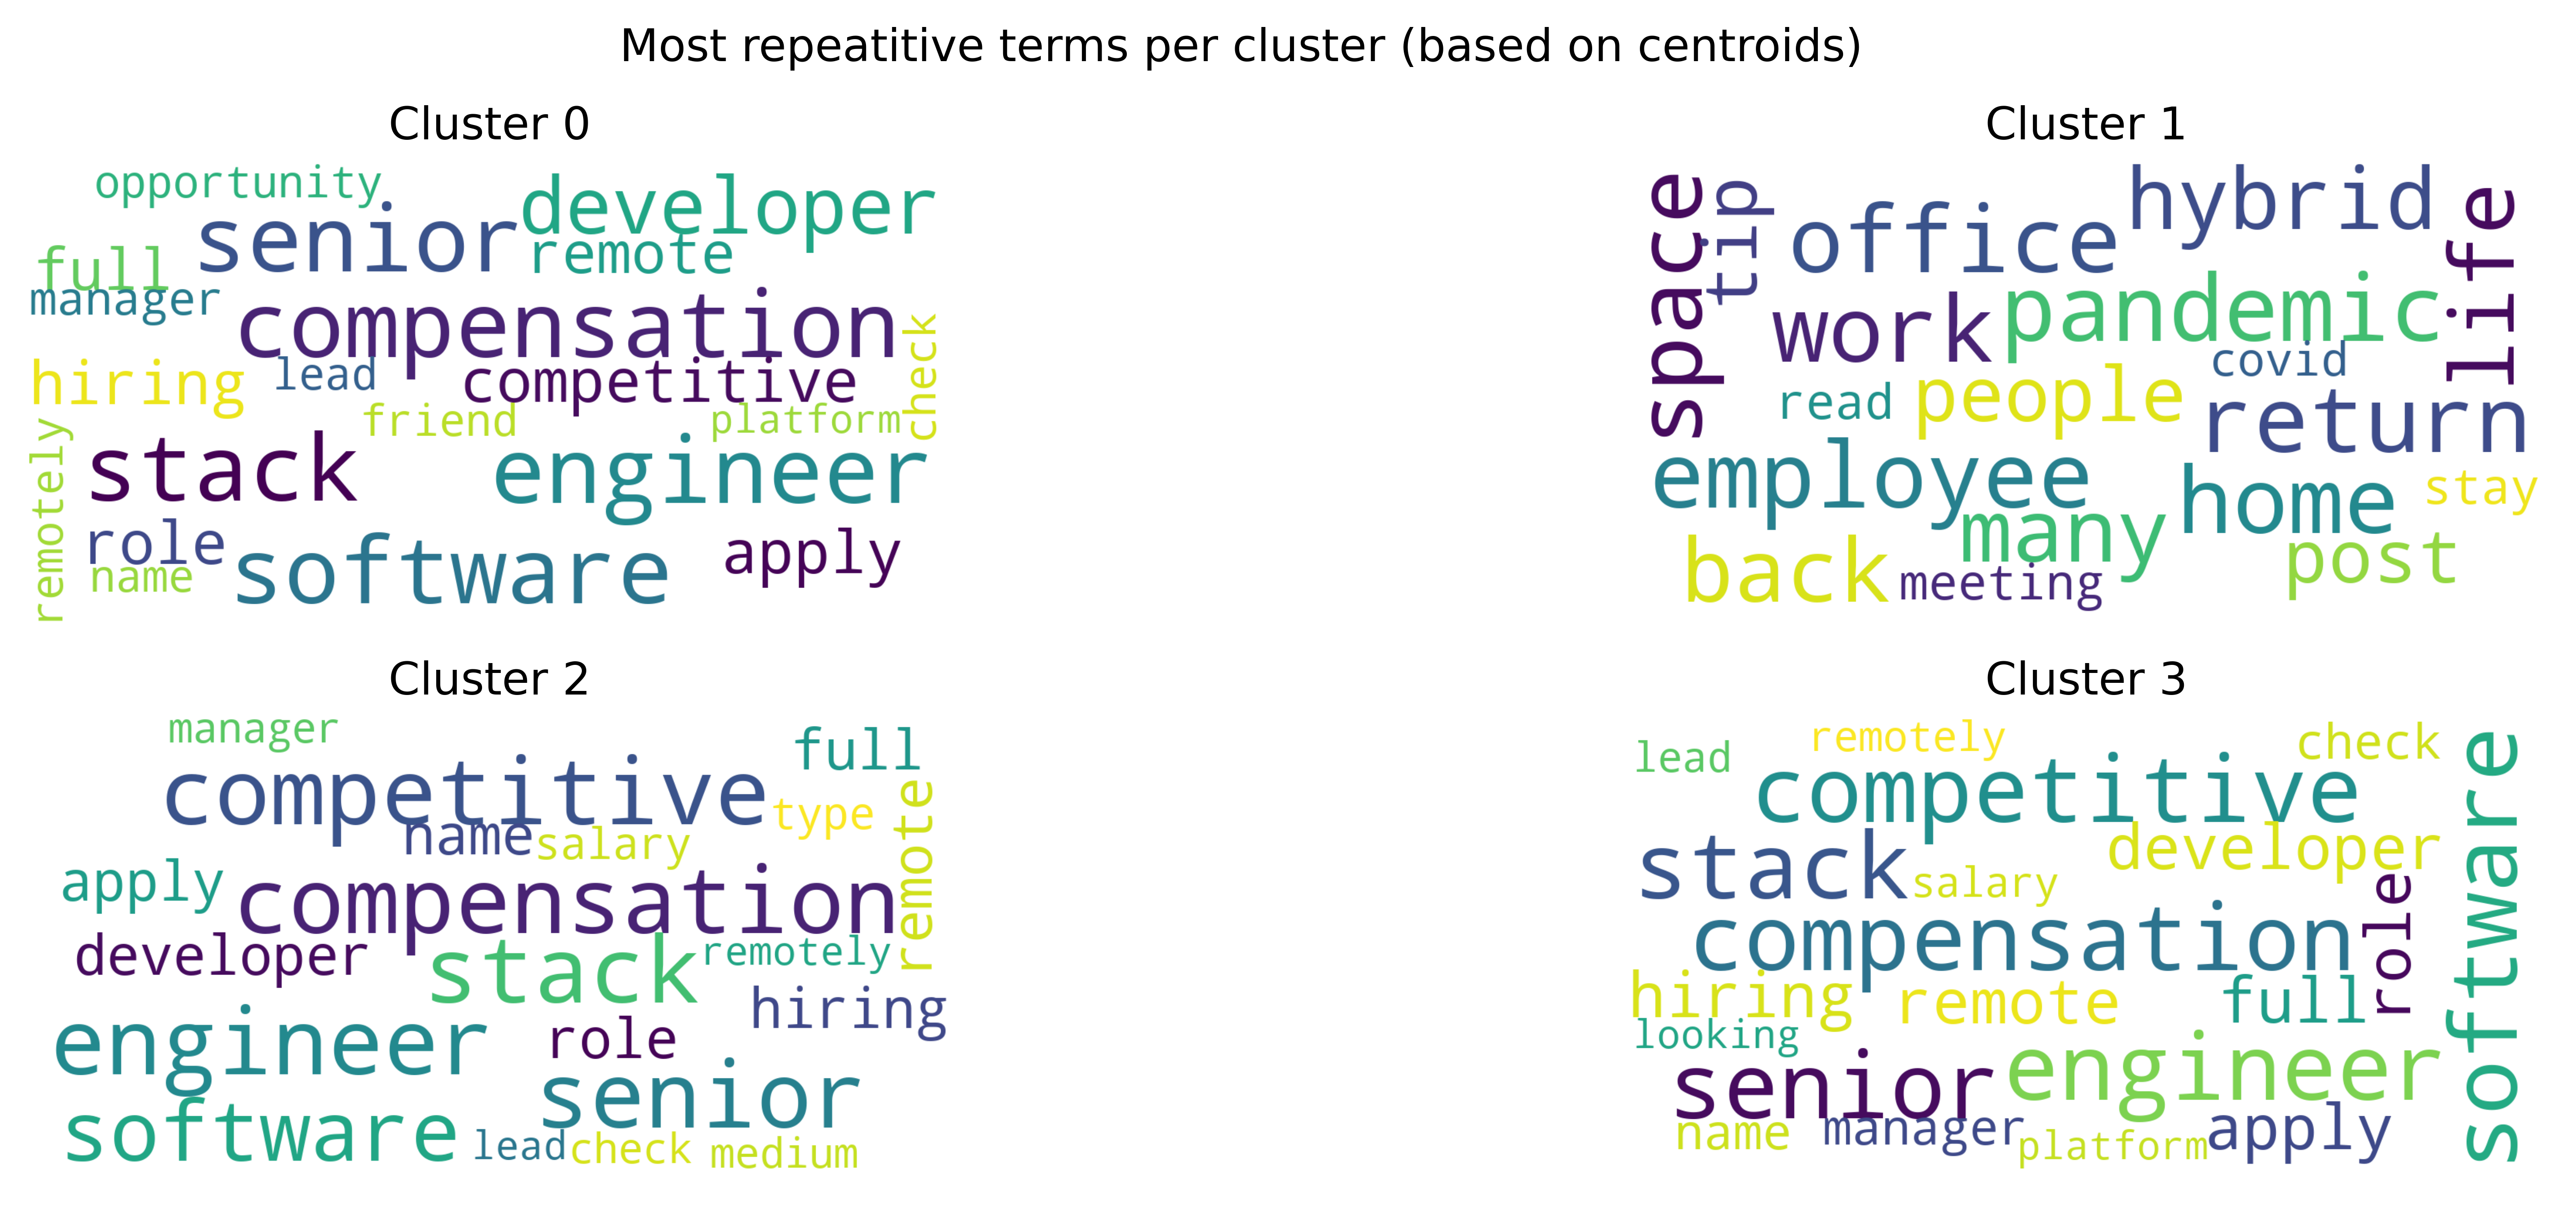

In [44]:
plt.subplots(2,2, figsize=(14,5),dpi=600)
plt.suptitle('Most repeatitive terms per cluster (based on centroids)')
for i in range(4):
    top_words = ""
    most_representative = model.wv.most_similar([km_vec.cluster_centers_[i]], topn=20)
    for t in most_representative:
        top_words += f"{t[0]} "
    wordcloud = WordCloud( background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(top_words);
    plt.subplot(2,2,i+1)
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.axis('off');
    plt.title(f"Cluster {i}");

In [45]:
#https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
#Print the tweets in each cluster to check for a pattern
def cluster_pattern(cluster,count):
    most_representative_docs = np.argsort(np.linalg.norm(X_vec_sc - km_vec.cluster_centers_[cluster], axis=1))
    for d in most_representative_docs[:count]:
        print(df_vec['tweets'][d])
        print("-------------")

In [50]:
cluster_pattern(2,5)

Ryan Shed Plans 12,000 Shed Plans and Designs For Easy Shed Building! — RyanShedPlans - https://t.co/0G0N6PkCZc #DIY #Workfromhome #DigitalPlans
-------------
Mask Cords to match your masks maybe ? 
#maskcords #wirewrappedjewelrycollection #wirewrappingtechnique #stainlesssteel #workfromhome #beadedcord #beadingismypassion❤💖💛 @ Bukit Panjang, Singapore https://t.co/Lhv9ROY6St
-------------
Up Now High-Interest Savings Accounts With Conditions: Are They Worth It? https://t.co/FpT15UW84j via @AJBCSurveys #workfromhome #jury-research https://t.co/Su21eTIsVK
-------------
Get the Edengate Farm Llc  green beans in for a nice steam...😉
Lunch is almost ready 😋 
#rockmartstyle #theoneandonly #tovalatime #workfromhome @ The Rockmart Farmers Market https://t.co/DPpmccNdia
-------------
What's the status of your spinal health, strong or weak? Tell us in the comments below!

#SpinalHealth #ChairDesign #Health #GoodHealth #Dynamic #Comfort #Convenience #Utility #Work #WorkFromHome #Boss #WorkFromOf

In [51]:
cluster_pattern(3,5)

🔥 New Remote Jobs:

– Brand Experience Designer ➔ https://t.co/qkdqvPA02C
– Python Developer ➔ https://t.co/YyGwHJesJN
– Customer Success Manager ➔ https://t.co/TsQ2QlXRE9
– Full-Stack Software Engineer ➔ https://t.co/r00lprMxU0

#RemoteWork #Designer #Python #FullStack
-------------
Dash is looking to hire a Senior Software Engineer 🔥 • Remote Anywhere • Apply now to be among the first candidates 👇

#javascript #blockchain #tendermint #techjobs #softwaredevelopment #remotejobs #workfromhome #GoRemote

https://t.co/VSh91dFfGu
-------------
We’re looking for people to #JoinTheHerd! #RemoteWork positions available: Senior Software Engineer (full-stack), Platform Solutions: Remote https://t.co/mjduknX7dS
-------------
We are looking for a lead full-stack developer that will help us build new products in the Carda...

Check out this Remote Lead Senior Full-Stack Developer role working with Api design, Redux &amp; Css

#remotework #remotejobs #apidesign #redux #css

https://t.co/IXfD3c11JU


In [52]:
cluster_pattern(0,5)

🏅Today’s featured article looks at the remote work skills you can include on your CV to help you gain a hiring managers attention. 

🆓 Sign up for FREE to read the article and more: https://t.co/SW14gXK5xW

#jobsearch #wfh #worklife #careers #CV #remotework #remoteworking https://t.co/0WQL3WytJN
-------------
We’re growing our team! We have open roles in Product, Marketing, Sales, Technology and Finance! If you want to make a difference at a growing tech company, find your future here! 

https://t.co/zibSjm2U0j 

#remotework #hiring #techjobs
-------------
Are you looking to start or continue a successful career in sales, and work remotely right from your home? SelectQuote is hiring AEP Sales Agents in 29 states. No experience necessary and warm leads provided: 
https://t.co/b00HKrXR8M 
#remotework #sqcareers
-------------
Our latest blog post features tips from enpact Program Manager Matthias Loker about the best Zoom games to play with teams and the remote collaboration tools we high

In [54]:
cluster_pattern(1,5)

The past year has proven many small businesses can operate from home. But there are still ways you can improve employee productivity and collaboration within the context of your remote or hybrid work strategy. Read here: https://t.co/qEdUhMoNP0 
#remotework https://t.co/2QXmXzInyL
-------------
Now that it's #FreedomDay today 🥳 we think it's a good time to look back and reflect on some of the things we learned while working from home over the last year ✌ What did you learn? Let us know! 👇👇

#WorkFromHome #BackToTheOffice #WolfPack https://t.co/C1O4NjeuYw https://t.co/6L5etCOTGa
-------------
Being alone isn't so bad because we sometimes need some space to think about how we're going to deal with our life challenges.😊
#generalVA #MByourRELIABLEdigitalVA #workfromhome #timemanagement #GraphicDesignVA #inspiredaily #successqoutes #mindset #marketing #socialmediamanager https://t.co/QAI5YjSu1r
-------------
For many office workers #COVID19 has radically changed how and where we work. In th

**Findings from analyzing both thw words and tweets per cluster**
- **Cluster_0 is about Remote Job Postings.Work Skills required for people are interested to work from home**
- **Did not find any pattern in Cluster_2 as most of the tweets had more hashtags than the text,here is no sync between the text and the hashtags used**
- **Cluster_1 is  about the impact of work from home which is what the project is about**
- **Cluster_3 is about remote job openings in IT Sector.Most of the job postings are for Front End Developer,BackendDeveloper,Full-Stack Developer**

In [55]:
wfh = df_vec.loc[df_vec.km == 1]

In [56]:
wfh

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,0,1,2,...,91,92,93,94,95,96,97,98,99,km
3,1416180231350759425,2021-07-16 23:37:33+00:00,🚑 These are the tools that will save your #Rem...,tool save google meet tool created love want know,"Duluth, GA",US,0,0.057402,0.035333,0.045828,...,0.250395,0.092509,0.094623,0.220986,0.060780,0.086350,-0.044944,0.020601,-0.051614,1
9,1416171154365091857,2021-07-16 23:01:29+00:00,The last 18 months have forever changed the wa...,last month forever changed work thrived many c...,Seattle,US,1,0.056812,0.033615,0.045274,...,0.258213,0.101440,0.091535,0.237126,0.065262,0.081273,-0.045810,0.024524,-0.053285,1
12,1416167740017188866,2021-07-16 22:47:55+00:00,Is Remote work still being used as leverage or...,remote work still used leverage called perk wo...,"Brisbane, Queensland",US,0,0.051365,0.033639,0.055488,...,0.259120,0.097375,0.090377,0.228785,0.056259,0.076938,-0.047636,0.020118,-0.050778,1
15,1416166255938187268,2021-07-16 22:42:01+00:00,Apple employees threaten to quit as company ta...,apple employee threaten quit company take hard...,#RemoteWork #Boston,US,0,0.059084,0.026675,0.057288,...,0.259815,0.115593,0.104453,0.239060,0.059646,0.086877,-0.050096,0.024859,-0.055890,1
21,1416158204975779847,2021-07-16 22:10:01+00:00,Timing is everything. Which days are the best ...,timing everything day best day work home tip pick,Global,None,1,0.060641,0.036592,0.015940,...,0.247269,0.104026,0.098054,0.239012,0.069066,0.085352,-0.038369,0.037122,-0.055268,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7092,1419001519349841923,2021-07-24 18:28:20+00:00,"Best part of working from home, playing video ...",best part working home playing video game lunc...,"Columbus, OH",US,1,0.063086,0.033794,0.031169,...,0.251997,0.102353,0.095759,0.232779,0.061223,0.081987,-0.045828,0.032812,-0.056755,1
7094,1418985424110952451,2021-07-24 17:24:23+00:00,"#remotework ""our amazing culture works best wh...",amazing culture work best people collaborate t...,United States,US,1,0.053786,0.026196,0.061872,...,0.248449,0.118331,0.104684,0.227076,0.058849,0.074374,-0.053330,0.025794,-0.058886,1
7095,1418985387087826946,2021-07-24 17:24:14+00:00,Work at a Fintech — Find high impact jobs at f...,work fintech find high impact job fast growing...,"Chicago, IL",US,1,0.063753,0.038073,0.040741,...,0.249875,0.099260,0.093710,0.225703,0.060456,0.077573,-0.039873,0.018938,-0.058579,1
7104,1418974501807738880,2021-07-24 16:40:59+00:00,Sorry @thebrokemonkey ! But this is the real r...,sorry real reason meeting much better passage ...,"Virginia, USA",US,0,0.067188,0.021285,0.033975,...,0.254989,0.104078,0.110351,0.221199,0.065120,0.078653,-0.028642,0.030106,-0.052627,1


/Users/yash/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


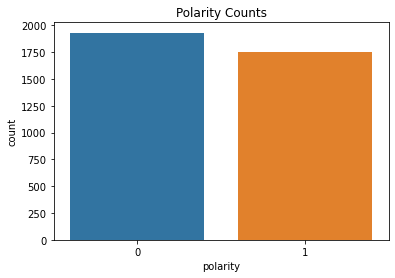

In [59]:
import seaborn as sns
sns.countplot(wfh["polarity"])
plt.title("Polarity Counts")
plt.show()

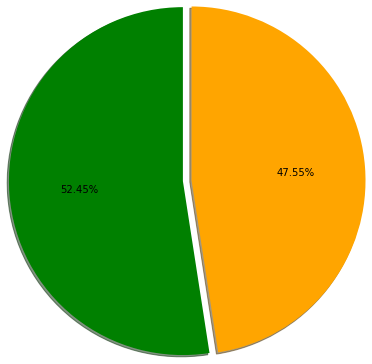

In [61]:
label = ['positive','negative']
colors = ['green', 'orange'] 
plt.pie(wfh['polarity'].value_counts(),colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), autopct = '%1.2f%%',radius=2) 
plt.show()

In [62]:
wfh['polarity'].value_counts(normalize=True)

0    0.524457
1    0.475543
Name: polarity, dtype: float64

In [100]:
wfh.to_csv('../dataset/wfh_cluster.csv',index=False)

In [122]:
wfh.loc[(wfh['user_location_cleaned']=='US')]

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,0,1,2,...,93,94,95,96,97,98,99,km,date,week_day
3,1416180231350759425,2021-07-16 23:37:33+00:00,🚑 These are the tools that will save your #Rem...,tool save google meet tool created love want know,"Duluth, GA",US,0,0.057402,0.035333,0.045828,...,0.094623,0.220986,0.060780,0.086350,-0.044944,0.020601,-0.051614,1,2021-07-16,Friday
9,1416171154365091857,2021-07-16 23:01:29+00:00,The last 18 months have forever changed the wa...,last month forever changed work thrived many c...,Seattle,US,1,0.056812,0.033615,0.045274,...,0.091535,0.237126,0.065262,0.081273,-0.045810,0.024524,-0.053285,1,2021-07-16,Friday
12,1416167740017188866,2021-07-16 22:47:55+00:00,Is Remote work still being used as leverage or...,remote work still used leverage called perk wo...,"Brisbane, Queensland",US,0,0.051365,0.033639,0.055488,...,0.090377,0.228785,0.056259,0.076938,-0.047636,0.020118,-0.050778,1,2021-07-16,Friday
15,1416166255938187268,2021-07-16 22:42:01+00:00,Apple employees threaten to quit as company ta...,apple employee threaten quit company take hard...,#RemoteWork #Boston,US,0,0.059084,0.026675,0.057288,...,0.104453,0.239060,0.059646,0.086877,-0.050096,0.024859,-0.055890,1,2021-07-16,Friday
22,1416157087529381898,2021-07-16 22:05:35+00:00,If you are required to return to working in an...,required return working office vaccinated mini...,"Columbus, OH",US,0,0.054723,0.046102,-0.000065,...,0.092026,0.241594,0.055039,0.087089,-0.033176,0.042671,-0.041677,1,2021-07-16,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7092,1419001519349841923,2021-07-24 18:28:20+00:00,"Best part of working from home, playing video ...",best part working home playing video game lunc...,"Columbus, OH",US,1,0.063086,0.033794,0.031169,...,0.095759,0.232779,0.061223,0.081987,-0.045828,0.032812,-0.056755,1,2021-07-24,Saturday
7094,1418985424110952451,2021-07-24 17:24:23+00:00,"#remotework ""our amazing culture works best wh...",amazing culture work best people collaborate t...,United States,US,1,0.053786,0.026196,0.061872,...,0.104684,0.227076,0.058849,0.074374,-0.053330,0.025794,-0.058886,1,2021-07-24,Saturday
7095,1418985387087826946,2021-07-24 17:24:14+00:00,Work at a Fintech — Find high impact jobs at f...,work fintech find high impact job fast growing...,"Chicago, IL",US,1,0.063753,0.038073,0.040741,...,0.093710,0.225703,0.060456,0.077573,-0.039873,0.018938,-0.058579,1,2021-07-24,Saturday
7104,1418974501807738880,2021-07-24 16:40:59+00:00,Sorry @thebrokemonkey ! But this is the real r...,sorry real reason meeting much better passage ...,"Virginia, USA",US,0,0.067188,0.021285,0.033975,...,0.110351,0.221199,0.065120,0.078653,-0.028642,0.030106,-0.052627,1,2021-07-24,Saturday


In [110]:
wfh['tweets'].loc[15]

'Apple employees threaten to quit as company takes hard line stance on #remotework https://t.co/SeXHdBbAWs'

In [117]:
wfh.loc[(wfh['user_location_cleaned']=='IN')]

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,0,1,2,...,93,94,95,96,97,98,99,km,date,week_day
84,1416112402995761156,2021-07-16 19:08:01+00:00,A Japanese company is approaching the #remotew...,japanese company approaching conundrum interes...,Australia + New Zealand + Asia,IN,0,0.058349,0.035927,0.020070,...,0.100280,0.243851,0.064020,0.085358,-0.040769,0.040996,-0.044320,1,2021-07-16,Friday
226,1416047950011281411,2021-07-16 14:51:54+00:00,The Rise of the Distributariat : (distributed ...,rise distributariat distributed work force shi...,Mumbai,IN,0,0.069688,0.039022,0.030232,...,0.105221,0.243201,0.063927,0.087844,-0.038342,0.027887,-0.055085,1,2021-07-16,Friday
234,1416045132084760577,2021-07-16 14:40:42+00:00,"Ultimately, to become more efficient, one has ...",ultimately become efficient travel le business...,Mumbai,IN,0,0.060773,0.039031,0.042448,...,0.094256,0.229957,0.069848,0.078703,-0.045926,0.021313,-0.059232,1,2021-07-16,Friday
299,1416022414010445829,2021-07-16 13:10:26+00:00,@StartingPointAI #Restyaboard is the best tool...,best tool remote work help team work faster pr...,"Chennai, India",IN,1,0.052971,0.025418,0.056116,...,0.094225,0.224608,0.059939,0.075744,-0.047678,0.017577,-0.050178,1,2021-07-16,Friday
335,1416005782265417739,2021-07-16 12:04:21+00:00,🧑‍💻 Here we are exploring nine ways to remain ...,exploring nine way remain productive whilst wo...,Hyderabad,IN,1,0.055333,0.045726,0.014486,...,0.091051,0.238214,0.062659,0.081900,-0.039665,0.038877,-0.047799,1,2021-07-16,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6832,1419496126093406215,2021-07-26 03:13:44+00:00,Limiting our work and focusing is the only way...,limiting work focusing gonna point high qualit...,Hamburg,IN,1,0.067972,0.039043,-0.000961,...,0.104109,0.253623,0.072241,0.074802,-0.037226,0.047177,-0.034748,1,2021-07-26,Monday
6940,1419292008741363715,2021-07-25 13:42:38+00:00,"Flexible work models are here to stay, but her...",flexible work model stay thing prey stress dis...,Coimbatore / Bangalore,IN,1,0.065716,0.035413,0.025058,...,0.102011,0.227709,0.064876,0.081654,-0.040934,0.030903,-0.050200,1,2021-07-25,Sunday
6993,1419202005394935808,2021-07-25 07:45:00+00:00,#ICYMI\n@MITSloan's @CultureXInsight discusses...,discus company achieve desired culture employe...,India,IN,0,0.044177,0.029485,0.063796,...,0.091271,0.225018,0.055108,0.083967,-0.050021,0.022743,-0.053241,1,2021-07-25,Sunday
7000,1419188262166425602,2021-07-25 06:50:23+00:00,Finally understand the need for multiple scree...,finally understand need multiple screen online...,"New Delhi, India",IN,0,0.071611,0.037621,0.029792,...,0.095059,0.235072,0.067791,0.089001,-0.042598,0.025704,-0.058922,1,2021-07-25,Sunday


In [114]:
wfh['tweets'].loc[381]

'#Apple employees are threatening to quit over the company’s “strict” #remotework  policy, which requires workers to be in office at least three days a week\nhttps://t.co/6ZwJkTfCZX'

In [121]:
wfh['tweets'].loc[84]

'A Japanese company is approaching the #remotework conundrum in an interesting way: It’s forcing employees who choose to work from home to pay those who show up at the office. https://t.co/rXMeCbbhxX via @HRD_Asia #HR #WFH'

In [123]:
wfh.loc[(wfh['user_location_cleaned']=='GB')]

,tweet_id,tweet_posted_on,tweets,cleaned_tweets,user_location,user_location_cleaned,polarity,0,1,2,...,93,94,95,96,97,98,99,km,date,week_day
26,1416155784405295114,2021-07-16 22:00:24+00:00,You need to adapt your processes for remote wo...,need adapt process remote work continue one de...,Surrey UK,GB,1,0.055878,0.030783,0.043472,...,0.090974,0.228966,0.059954,0.077943,-0.046362,0.024440,-0.048515,1,2021-07-16,Friday
58,1416130362539925512,2021-07-16 20:19:23+00:00,A comprehensive guide to remote work for both ...,comprehensive guide remote work home worker co...,Surrey UK,GB,1,0.045684,0.027152,0.065225,...,0.091930,0.227811,0.060807,0.074497,-0.052297,0.018178,-0.052412,1,2021-07-16,Friday
107,1416101047303553035,2021-07-16 18:22:54+00:00,Even the US Space Forces are now working remot...,even space force working remotely earth earth ...,"England, United Kingdom",GB,1,0.048954,0.030612,0.048214,...,0.089465,0.227707,0.060660,0.081510,-0.042901,0.022197,-0.055684,1,2021-07-16,Friday
111,1416100163932856326,2021-07-16 18:19:23+00:00,"15 years ago line speeds were poor, videoconfe...",year line speed poor videoconferencing interne...,Surrey UK,GB,0,0.052460,0.042055,0.032877,...,0.096154,0.239866,0.065099,0.079526,-0.042493,0.028201,-0.054751,1,2021-07-16,Friday
167,1416067699961212933,2021-07-16 16:10:23+00:00,Read Remote Work The New Normal. For those wo...,read remote work normal working home likely wo...,Surrey UK,GB,1,0.049973,0.038881,0.033809,...,0.090697,0.237052,0.060108,0.081992,-0.045523,0.029004,-0.050523,1,2021-07-16,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6746,1417278278415622158,2021-07-20 00:20:47+00:00,Recruitment Resourcer (Work from Home Option)\...,recruitment resourcer work home option square ...,United Kingdom UK GB,GB,0,0.066803,0.042172,-0.010219,...,0.099303,0.250106,0.072341,0.081992,-0.031793,0.051877,-0.041060,1,2021-07-20,Tuesday
6788,1417205432645455878,2021-07-19 19:31:20+00:00,"How many people, genuinely wake up one morning...",many people genuinely wake morning quit work l...,United Kingdom,GB,0,0.061385,0.035149,0.033443,...,0.103228,0.241000,0.060571,0.076002,-0.048168,0.031584,-0.053192,1,2021-07-19,Monday
6988,1419208312562896897,2021-07-25 08:10:03+00:00,The way that many employers are organising Hyb...,many employer organising hybrid costly maintai...,Surrey UK,GB,0,0.049143,0.030943,0.064023,...,0.097986,0.229624,0.058629,0.075249,-0.051454,0.019432,-0.059789,1,2021-07-25,Sunday
7025,1419109908859994119,2021-07-25 01:39:02+00:00,Is hybrid worth it - Yes! But not the way th...,hybrid worth many employer organising read add...,Surrey UK,GB,1,0.060963,0.035620,0.020209,...,0.094951,0.239870,0.060376,0.080673,-0.035807,0.032744,-0.045983,1,2021-07-25,Sunday


In [124]:
wfh['tweets'].loc[7025]

'Is hybrid worth it  - Yes!  But not the way that many employers are organising it.  Read about the added costs,  risks and issues with Hybrid work. https://t.co/GGGZLQRfk7 #remotework #remotejobs  #remotework #HybridWorkforce #FutureOfWork https://t.co/4MkZsAjKWm'

In [125]:
wfh['tweets'].loc[7039]

'Is hybrid worth it  - Yes!  But not the way that many employers are organising it which is expensive and just about as inefficient a work model as you could come up with. https://t.co/GGGZLQRfk7 #remotework #remotejobs  #remotework #HybridWorkforce #FutureOfWork https://t.co/cetpPxwac5'

In [126]:
wfh['tweets'].loc[107]

'Even the US Space Forces are now working remotely on Earth…#remotework. This Earth is not hard after all! Keep smiling! https://t.co/hfWtkn21Lc'